<a href="https://colab.research.google.com/github/nigamreetesh84/predict-fraudulent-credit-card-transactions/blob/main/Credit_card_fraud_detection_Starter_code_reetesh_nigam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV,
    RandomizedSearchCV, learning_curve, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve,
    precision_recall_curve, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.calibration import calibration_curve

from imblearn import over_sampling
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"SHAP: {SHAP_AVAILABLE}")
print("="*70)

ENVIRONMENT INFORMATION
Python: 3.12.12
NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1
XGBoost: 3.1.2
SHAP: True


In [2]:
# ============================================================================
# DATASET DIAGNOSTIC & REPAIR TOOL
# ============================================================================


import pandas as pd
import numpy as np

print("="*70)
print("DATASET DIAGNOSTIC TOOL")
print("="*70)


try:
    df = pd.read_csv('/content/sample_data/creditcard.csv')
    print(f"✓ Dataset loaded: {df.shape}")
except Exception as e:
    print(f"❌ ERROR loading dataset: {e}")
    print("\nTroubleshooting:")
    print("1. Check file exists: ls creditcard.csv")
    print("2. Check file permissions")

    raise

# Detailed diagnostic
print("\n" + "="*70)
print("DIAGNOSTIC REPORT")
print("="*70)

# 1. Missing values analysis
print("\n1. MISSING VALUES ANALYSIS")
print("-" * 70)
missing_summary = df.isnull().sum()
total_missing = missing_summary.sum()

if total_missing > 0:
    print(f"⚠️  FOUND {total_missing} MISSING VALUES")
    print("\nBreakdown by column:")
    for col, count in missing_summary[missing_summary > 0].items():
        pct = (count / len(df)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")

    # Show sample rows with missing values
    print("\nSample rows with missing values:")
    print(df[df.isnull().any(axis=1)].head())
else:
    print("✓ NO MISSING VALUES")

# 2. Data types check
print("\n2. DATA TYPES")
print("-" * 70)
print(df.dtypes)

# Check for unexpected data types
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if 'Class' in non_numeric:
    non_numeric.remove('Class')
if non_numeric:
    print(f"\n⚠️  Non-numeric columns found: {non_numeric}")

# 3. Duplicate rows
print("\n3. DUPLICATE ROWS")
print("-" * 70)
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"⚠️  Found {duplicates} duplicate rows")
else:
    print("✓ No duplicates")

# 4. Class distribution
print("\n4. CLASS DISTRIBUTION")
print("-" * 70)
if 'Class' in df.columns:
    class_counts = df['Class'].value_counts()
    print(class_counts)
    print(f"\nFraud percentage: {class_counts.get(1, 0) / len(df) * 100:.4f}%")
else:
    print("❌ 'Class' column not found!")

# 5. Check for infinite values
print("\n5. INFINITE VALUES CHECK")
print("-" * 70)
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f"⚠️  Found {inf_count} infinite values")
    inf_cols = df.select_dtypes(include=[np.number]).columns[
        np.isinf(df.select_dtypes(include=[np.number])).any()
    ].tolist()
    print(f"  Columns with inf: {inf_cols}")
else:
    print("✓ No infinite values")

# 6. Value ranges
print("\n6. VALUE RANGES (SAMPLE)")
print("-" * 70)
print(df.describe().T[['min', 'max', 'mean', 'std']].head(10))

# ============================================================================
# AUTOMATIC DATA CLEANING
# ============================================================================

print("\n" + "="*70)
print("AUTOMATIC DATA CLEANING")
print("="*70)

original_shape = df.shape
issues_fixed = []

# Fix 1: Remove rows with missing values
if df.isnull().sum().sum() > 0:
    before = len(df)
    df = df.dropna()
    after = len(df)
    issues_fixed.append(f"Removed {before - after} rows with missing values")
    print(f"✓ Removed {before - after} rows with missing values")

# Fix 2: Remove duplicate rows
if df.duplicated().sum() > 0:
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    issues_fixed.append(f"Removed {before - after} duplicate rows")
    print(f"✓ Removed {before - after} duplicate rows")

# Fix 3: Replace infinite values with NaN and drop
inf_mask = np.isinf(df.select_dtypes(include=[np.number]))
if inf_mask.any().any():
    before = len(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    after = len(df)
    issues_fixed.append(f"Removed {before - after} rows with infinite values")
    print(f"✓ Removed {before - after} rows with infinite values")

# Fix 4: Ensure Class column is binary
if 'Class' in df.columns:
    if not df['Class'].isin([0, 1]).all():
        print("⚠️  Non-binary values in Class column, removing...")
        before = len(df)
        df = df[df['Class'].isin([0, 1])]
        after = len(df)
        issues_fixed.append(f"Removed {before - after} rows with invalid Class values")
        print(f"✓ Removed {before - after} rows with invalid Class values")

# Final verification
print("\n" + "="*70)
print("CLEANED DATASET SUMMARY")
print("="*70)
print(f"Original shape: {original_shape}")
print(f"Cleaned shape:  {df.shape}")
print(f"Rows removed:   {original_shape[0] - df.shape[0]}")
print(f"Data loss:      {(original_shape[0] - df.shape[0]) / original_shape[0] * 100:.2f}%")

if issues_fixed:
    print(f"\nIssues fixed:")
    for issue in issues_fixed:
        print(f"  • {issue}")
else:
    print("\n✓ Dataset was already clean!")

# Final checks
print("\n" + "="*70)
print("FINAL VALIDATION")
print("="*70)

checks_passed = []
checks_failed = []

# Check 1: No missing values
if df.isnull().sum().sum() == 0:
    checks_passed.append("No missing values")
    print("✓ No missing values")
else:
    checks_failed.append(f"Still has {df.isnull().sum().sum()} missing values")
    print(f"❌ Still has {df.isnull().sum().sum()} missing values")

# Check 2: Class column exists
if 'Class' in df.columns:
    checks_passed.append("Class column exists")
    print("✓ Class column exists")
else:
    checks_failed.append("Class column missing")
    print("❌ Class column missing")

# Check 3: Binary class labels
if 'Class' in df.columns and df['Class'].isin([0, 1]).all():
    checks_passed.append("Class labels are binary")
    print("✓ Class labels are binary")
else:
    checks_failed.append("Invalid class labels")
    print("❌ Invalid class labels")

# Check 4: Minimum size
if len(df) > 100000:
    checks_passed.append(f"Sufficient data ({len(df):,} rows)")
    print(f"✓ Sufficient data ({len(df):,} rows)")
else:
    checks_failed.append(f"Insufficient data ({len(df):,} rows)")
    print(f"⚠️  Insufficient data ({len(df):,} rows)")

print("\n" + "="*70)
if len(checks_failed) == 0:
    print("✅ ALL CHECKS PASSED - DATASET READY FOR ANALYSIS")
    print("="*70)
    print("\nYou can now proceed with the rest of the notebook.")
    print("The cleaned dataset is stored in variable: df")
else:
    print("❌ SOME CHECKS FAILED")
    print("="*70)
    for check in checks_failed:
        print(f"  • {check}")
    print("\nPlease fix these issues before proceeding.")

# Save cleaned dataset (optional)
save_cleaned = False  # Set to True if you want to save
if save_cleaned and issues_fixed:
    output_file = 'creditcard_cleaned.csv'
    df.to_csv(output_file, index=False)
    print(f"\n💾 Cleaned dataset saved as: {output_file}")

DATASET DIAGNOSTIC TOOL
✓ Dataset loaded: (51591, 31)

DIAGNOSTIC REPORT

1. MISSING VALUES ANALYSIS
----------------------------------------------------------------------
⚠️  FOUND 20 MISSING VALUES

Breakdown by column:
  • V11: 1 (0.00%)
  • V12: 1 (0.00%)
  • V13: 1 (0.00%)
  • V14: 1 (0.00%)
  • V15: 1 (0.00%)
  • V16: 1 (0.00%)
  • V17: 1 (0.00%)
  • V18: 1 (0.00%)
  • V19: 1 (0.00%)
  • V20: 1 (0.00%)
  • V21: 1 (0.00%)
  • V22: 1 (0.00%)
  • V23: 1 (0.00%)
  • V24: 1 (0.00%)
  • V25: 1 (0.00%)
  • V26: 1 (0.00%)
  • V27: 1 (0.00%)
  • V28: 1 (0.00%)
  • Amount: 1 (0.00%)
  • Class: 1 (0.00%)

Sample rows with missing values:
        Time       V1        V2        V3        V4        V5        V6  \
51590  45026  1.04238 -1.096464  0.234271 -0.615254 -1.243107 -0.714834   

             V7        V8        V9  ...  V21  V22  V23  V24  V25  V26  V27  \
51590 -0.433026 -0.084918 -0.946072  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       V28  Amount  Class  
51590  NaN     NaN   


EXPLORATORY DATA ANALYSIS

Class Distribution:
Class
0.0    51214
1.0      150
Name: count, dtype: int64
Fraud %: 0.2920%
Imbalance Ratio: 1:341


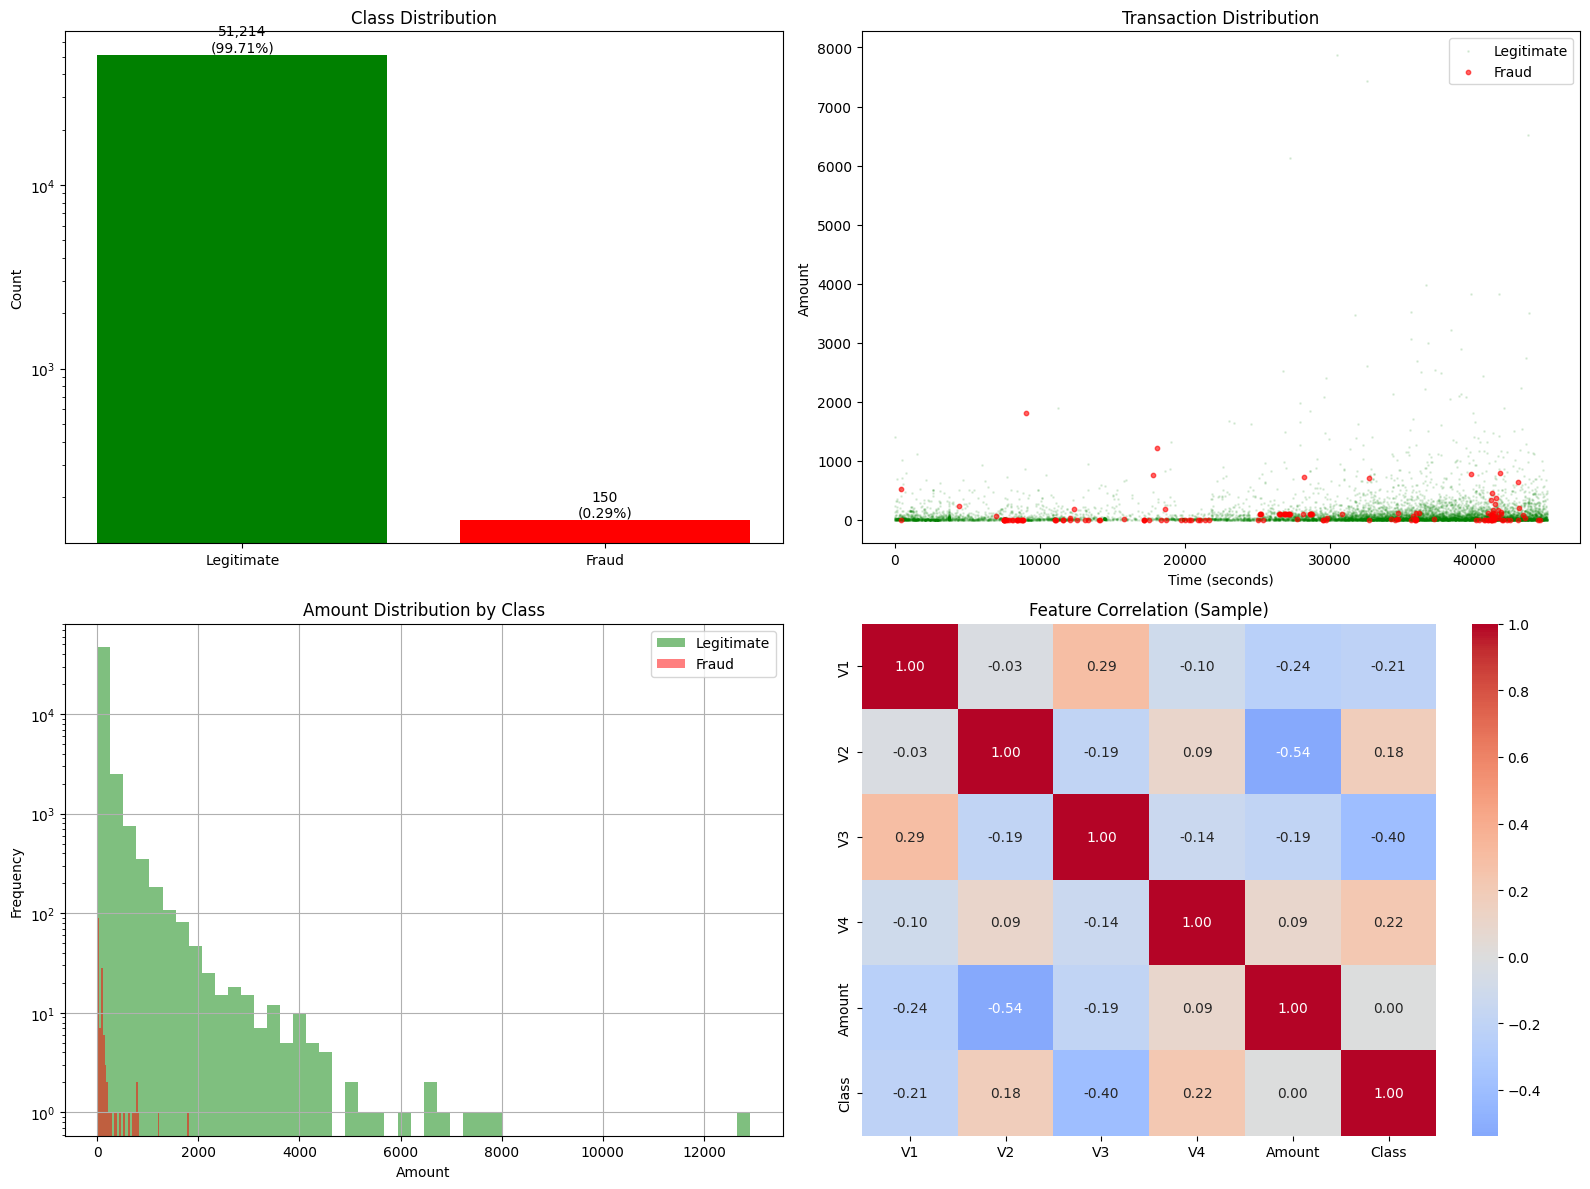

✓ EDA saved: eda_overview.png


In [3]:
print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

class_counts = df['Class'].value_counts()
print(f"\nClass Distribution:")
print(class_counts)
print(f"Fraud %: {class_counts[1]/len(df)*100:.4f}%")
print(f"Imbalance Ratio: 1:{class_counts[0]/class_counts[1]:.0f}")

# OPTIMIZED: Downsample for visualization speed
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Class Distribution
axes[0,0].bar(['Legitimate', 'Fraud'], class_counts.values, color=['green', 'red'])
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Class Distribution')
axes[0,0].set_yscale('log')
for i, v in enumerate(class_counts.values):
    axes[0,0].text(i, v, f'{v:,}\n({v/len(df)*100:.2f}%)', ha='center', va='bottom')

# 2. Time Distribution (OPTIMIZED: Sample 10k points)
sample_size = min(10000, len(df[df['Class']==0]))
df_sample_0 = df[df['Class']==0].sample(n=sample_size, random_state=RANDOM_STATE)
df_fraud = df[df['Class']==1]

axes[0,1].scatter(df_sample_0['Time'], df_sample_0['Amount'],
                  alpha=0.1, s=1, label='Legitimate', c='green')
axes[0,1].scatter(df_fraud['Time'], df_fraud['Amount'],
                  alpha=0.6, s=10, label='Fraud', c='red')
axes[0,1].set_xlabel('Time (seconds)')
axes[0,1].set_ylabel('Amount')
axes[0,1].set_title('Transaction Distribution')
axes[0,1].legend()

# 3. Amount Distribution
df[df['Class']==0]['Amount'].hist(bins=50, alpha=0.5, label='Legitimate',
                                   ax=axes[1,0], color='green')
df[df['Class']==1]['Amount'].hist(bins=50, alpha=0.5, label='Fraud',
                                   ax=axes[1,0], color='red')
axes[1,0].set_xlabel('Amount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Amount Distribution by Class')
axes[1,0].set_yscale('log')
axes[1,0].legend()

# 4. Correlation Heatmap
features_sample = ['V1', 'V2', 'V3', 'V4', 'Amount', 'Class']
sns.heatmap(df[features_sample].corr(), annot=True, fmt='.2f',
            cmap='coolwarm', ax=axes[1,1], center=0)
axes[1,1].set_title('Feature Correlation (Sample)')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ EDA saved: eda_overview.png")

In [4]:
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']
print(f"✓ Features: {X.shape}")
print(f"✓ Target: {y.shape}")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

print(f"\n✓ Train: {X_train.shape[0]} samples ({y_train.sum()} frauds)")
print(f"✓ Test: {X_test.shape[0]} samples ({y_test.sum()} frauds)")

# Power Transformation
print("\nApplying Power Transformation...")
pt = preprocessing.PowerTransformer(method='yeo-johnson', copy=True)
X_train = pd.DataFrame(pt.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(pt.transform(X_test), columns=X_test.columns, index=X_test.index)
print("✓ Transformation complete")


DATA PREPROCESSING
✓ Features: (51364, 29)
✓ Target: (51364,)

✓ Train: 35954 samples (105.0 frauds)
✓ Test: 15410 samples (45.0 frauds)

Applying Power Transformation...
✓ Transformation complete


In [5]:
# ============================================================================
# SECTION 5: MODEL BUILDING - ULTRA-OPTIMIZED
# ============================================================================

print("\n" + "="*70)
print("PHASE 1: MODELS ON IMBALANCED DATA (ULTRA-OPTIMIZED)")
print("="*70)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)  # 3 folds instead of 5
scoring = 'roc_auc'

# ULTRA-OPTIMIZED: Smaller grids, removed SVM
models_imbalanced = {
    'Logistic Regression': {
        'model': LogisticRegression(solver='liblinear', class_weight='balanced',
                                    random_state=RANDOM_STATE, max_iter=1000),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l2']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [5, 7], 'weights': ['distance'], 'metric': ['euclidean']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
        'params': {'max_depth': [5, 7, 10], 'min_samples_split': [2], 'criterion': ['gini']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_estimators=50, class_weight='balanced',
                                       random_state=RANDOM_STATE, n_jobs=-1),
        'params': {'max_depth': [6, 8], 'max_features': ['sqrt']}
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='auc',
                              scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
                              random_state=RANDOM_STATE, n_jobs=-1),
        'params': {'max_depth': [3, 5], 'learning_rate': [0.1], 'n_estimators': [100]}
    }
}

print("\nTraining models ...\n")

best_models_imbalanced = {}
imbalanced_results = []

for name, config in models_imbalanced.items():
    print(f"Training {name}...")

    if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        search = RandomizedSearchCV(config['model'], config['params'],
                                   n_iter=6, scoring=scoring, cv=cv,
                                   n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
    else:
        search = GridSearchCV(config['model'], config['params'],
                             scoring=scoring, cv=cv, n_jobs=-1, verbose=0)

    search.fit(X_train, y_train)
    best_models_imbalanced[name] = search.best_estimator_

    imbalanced_results.append({
        'Model': name,
        'Best_Params': str(search.best_params_),
        'CV_ROC_AUC': search.best_score_,
        'CV_Time_Sec': search.refit_time_
    })

    print(f"  ✓ CV ROC-AUC: {search.best_score_:.4f}, Time: {search.refit_time_:.2f}s\n")


PHASE 1: MODELS ON IMBALANCED DATA (ULTRA-OPTIMIZED)

Training models ...

Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9643, Time: 0.57s

Training KNN...
  ✓ CV ROC-AUC: 0.9569, Time: 0.01s

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9412, Time: 1.16s

Training Random Forest...
  ✓ CV ROC-AUC: 0.9736, Time: 3.90s

Training XGBoost...
  ✓ CV ROC-AUC: 0.9843, Time: 1.22s



In [6]:

# ============================================================================
# SECTION 6: EVALUATION FUNCTION
# ============================================================================

def evaluate_model_comprehensive(model, X_test, y_test, model_name,
                                  sampling_method='None', threshold=0.5):
    """Comprehensive model evaluation"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    total_frauds = tp + fn
    total_normal = tn + fp

    return {
        'Model': model_name,
        'Sampling': sampling_method,
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1_Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'PR_AUC': average_precision_score(y_test, y_pred_proba),
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp,
        'Frauds_Detected': tp,
        'Total_Frauds': total_frauds,
        'Fraud_Detection_Rate': tp / total_frauds if total_frauds > 0 else 0,
        'False_Alarm_Rate': fp / total_normal if total_normal > 0 else 0,
        'Total_Cost': (fp * 5) + (fn * 100),
        'Cost_Per_Transaction': ((fp * 5) + (fn * 100)) / len(y_test)
    }

# Evaluate imbalanced models
print("\n" + "="*70)
print("IMBALANCED DATA - TEST EVALUATION")
print("="*70)

test_results_imbalanced = []
for name, model in best_models_imbalanced.items():
    results = evaluate_model_comprehensive(model, X_test, y_test, name, 'Imbalanced')
    test_results_imbalanced.append(results)

test_df_imbalanced = pd.DataFrame(test_results_imbalanced)
key_metrics = ['Model', 'Recall', 'Precision', 'F1_Score', 'ROC_AUC',
               'PR_AUC', 'Frauds_Detected', 'Total_Cost']
print("\n" + test_df_imbalanced[key_metrics].to_string(index=False))


IMBALANCED DATA - TEST EVALUATION

              Model   Recall  Precision  F1_Score  ROC_AUC   PR_AUC  Frauds_Detected  Total_Cost
Logistic Regression 0.977778   0.123249  0.218905 0.995031 0.729456               44        1665
                KNN 0.822222   0.925000  0.870588 0.944280 0.872495               37         815
      Decision Tree 0.888889   0.136519  0.236686 0.941920 0.374674               40        1765
      Random Forest 0.866667   0.795918  0.829787 0.998311 0.896250               39         650
            XGBoost 0.933333   0.777778  0.848485 0.999469 0.945014               42         360



PHASE 2: MODELS ON BALANCED DATA (OPTIMIZED)

Visualizing sampling methods...


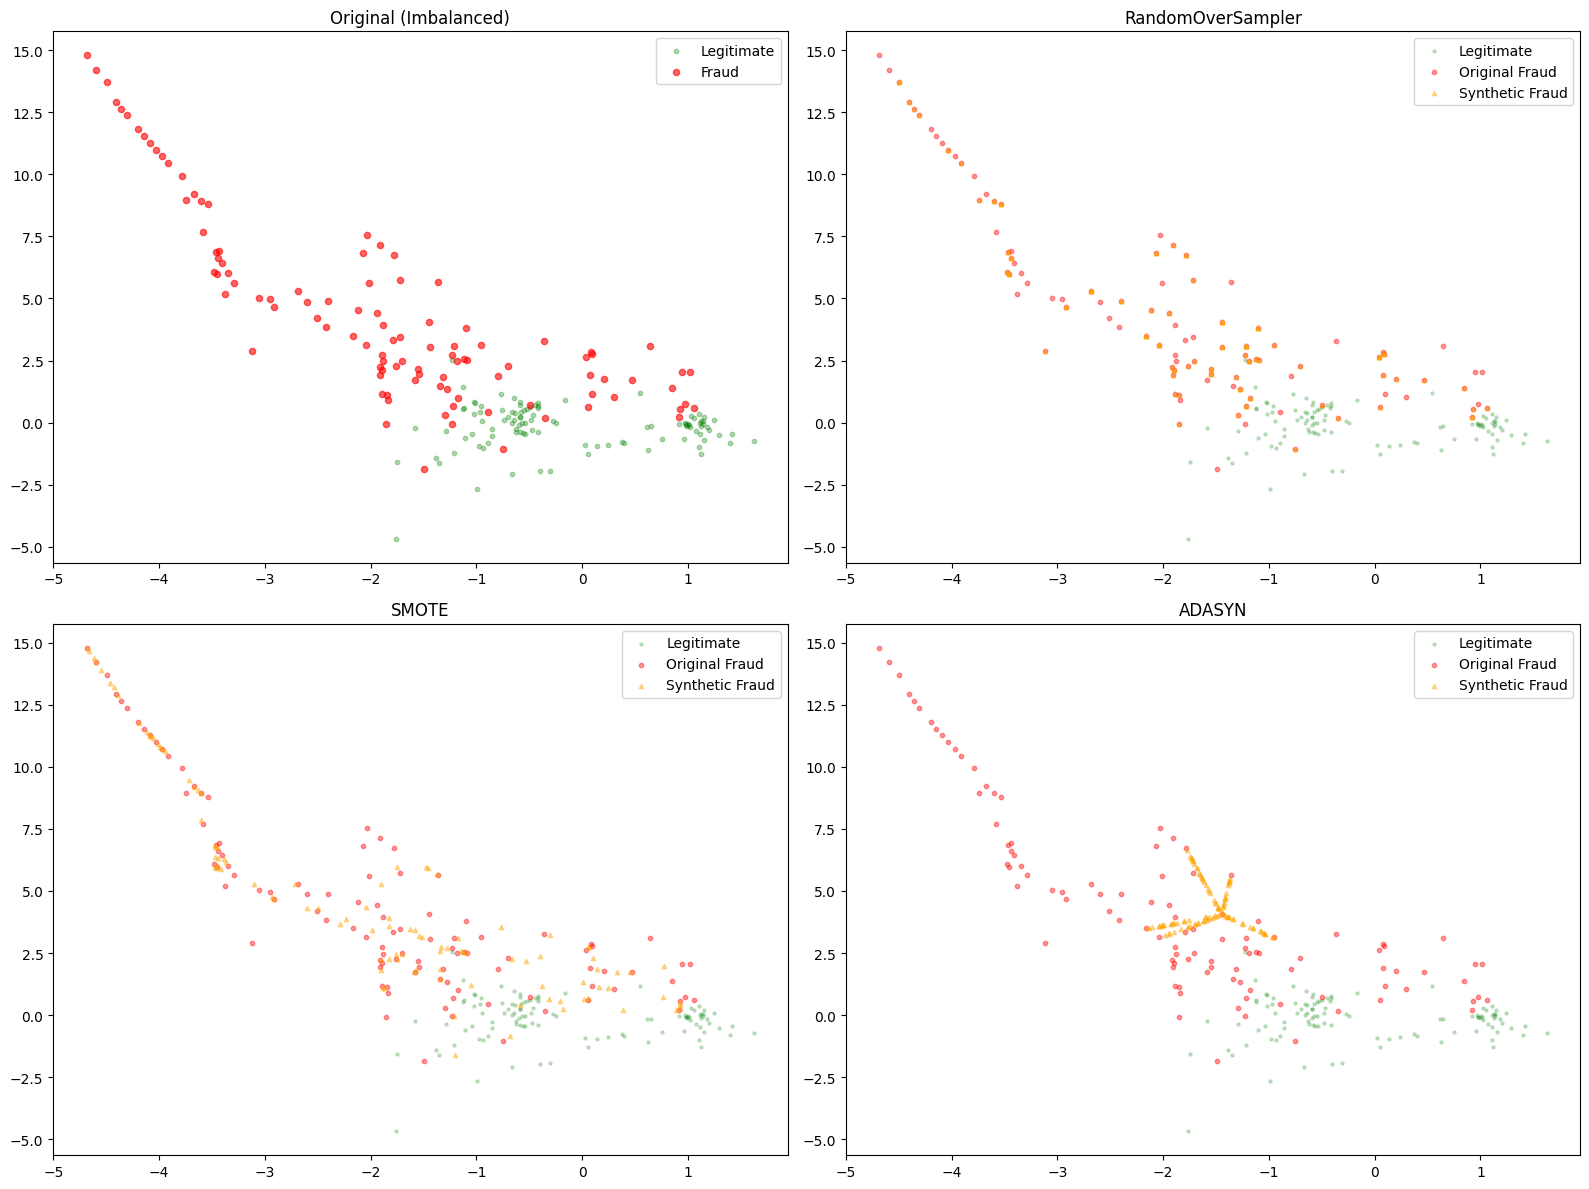

✓ Sampling visualization saved

Training balanced models (ETA: 8-12 minutes)...


SAMPLING: RandomOverSampler
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9624

Training KNN...
  ✓ CV ROC-AUC: 0.9569

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9412

Training Random Forest...
  ✓ CV ROC-AUC: 0.9778

Training XGBoost...
  ✓ CV ROC-AUC: 0.9734


SAMPLING: SMOTE
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9621

Training KNN...
  ✓ CV ROC-AUC: 0.9567

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9392

Training Random Forest...
  ✓ CV ROC-AUC: 0.9867

Training XGBoost...
  ✓ CV ROC-AUC: 0.9732


SAMPLING: ADASYN
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9567

Training KNN...
  ✓ CV ROC-AUC: 0.9567

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9620

Training Random Forest...
  ✓ CV ROC-AUC: 0.9878

Training XGBoost...
  ✓ CV ROC-AUC: 0.9724


BALANCED DATA - CV RESULTS
         Sampling               Model  CV_ROC_AUC                                                          

In [7]:
# ============================================================================
# SECTION 7: CLASS BALANCING WITH SAMPLING
# ============================================================================

print("\n" + "="*70)
print("PHASE 2: MODELS ON BALANCED DATA ")
print("="*70)

samplers = {
    'RandomOverSampler': over_sampling.RandomOverSampler(random_state=RANDOM_STATE),
    'SMOTE': over_sampling.SMOTE(random_state=RANDOM_STATE),
    'ADASYN': over_sampling.ADASYN(random_state=RANDOM_STATE)
}

# OPTIMIZED: Visualize with smaller sample
print("\nVisualizing sampling methods...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

X_train_1 = X_train[y_train==1].values
X_train_0 = X_train[y_train==0].values
np.random.seed(RANDOM_STATE)
np.random.shuffle(X_train_0)

vis_sample_size = min(500, len(X_train_1))  # OPTIMIZED

axes[0,0].scatter(X_train_0[:vis_sample_size, 0], X_train_0[:vis_sample_size, 1],
                  alpha=0.3, s=10, label='Legitimate', c='green')
axes[0,0].scatter(X_train_1[:vis_sample_size, 0], X_train_1[:vis_sample_size, 1],
                  alpha=0.6, s=20, label='Fraud', c='red')
axes[0,0].set_title('Original (Imbalanced)')
axes[0,0].legend()

for idx, (sampler_name, sampler) in enumerate(samplers.items(), 1):
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_synthetic = X_resampled[len(X_train):].values

    synthetic_sample = min(vis_sample_size, len(X_synthetic))  # OPTIMIZED

    axes.flatten()[idx].scatter(X_train_0[:vis_sample_size, 0],
                                X_train_0[:vis_sample_size, 1],
                                alpha=0.2, s=5, label='Legitimate', c='green')
    axes.flatten()[idx].scatter(X_train_1[:vis_sample_size, 0],
                                X_train_1[:vis_sample_size, 1],
                                alpha=0.4, s=10, label='Original Fraud', c='red')
    axes.flatten()[idx].scatter(X_synthetic[:synthetic_sample, 0],
                                X_synthetic[:synthetic_sample, 1],
                                alpha=0.4, s=10, label='Synthetic Fraud',
                                c='orange', marker='^')
    axes.flatten()[idx].set_title(f'{sampler_name}')
    axes.flatten()[idx].legend()

plt.tight_layout()
plt.savefig('sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Sampling visualization saved")

# Train models on balanced data
print("\nTraining balanced models (ETA: 8-12 minutes)...\n")

best_models_balanced = {}
balanced_results = []

for sampler_name, sampler in samplers.items():
    print(f"\n{'='*70}")
    print(f"SAMPLING: {sampler_name}")
    print(f"{'='*70}")

    for model_name, config in models_imbalanced.items():
        print(f"Training {model_name}...")

        pipeline = ImbPipeline([
            ('sampler', sampler),
            ('classifier', config['model'])
        ])

        params_pipeline = {f'classifier__{k}': v for k, v in config['params'].items()}

        # OPTIMIZED: Reduced n_iter
        if model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
            search = RandomizedSearchCV(pipeline, params_pipeline, n_iter=12,
                                       scoring=scoring, cv=cv, n_jobs=-1,
                                       random_state=RANDOM_STATE, verbose=0)
        else:
            search = GridSearchCV(pipeline, params_pipeline, scoring=scoring,
                                 cv=cv, n_jobs=-1, verbose=0)

        search.fit(X_train, y_train)

        key = f"{sampler_name}_{model_name}"
        best_models_balanced[key] = search.best_estimator_

        balanced_results.append({
            'Sampling': sampler_name,
            'Model': model_name,
            'CV_ROC_AUC': search.best_score_,
            'Best_Params': str(search.best_params_)
        })

        print(f"  ✓ CV ROC-AUC: {search.best_score_:.4f}\n")

balanced_cv_df = pd.DataFrame(balanced_results)
print("\n" + "="*70)
print("BALANCED DATA - CV RESULTS")
print("="*70)
print(balanced_cv_df.to_string(index=False))

# Evaluate balanced models
print("\n" + "="*70)
print("BALANCED DATA - TEST EVALUATION")
print("="*70)

test_results_balanced = []
for key, model in best_models_balanced.items():
    sampler_name, model_name = key.split('_', 1)
    results = evaluate_model_comprehensive(model, X_test, y_test,
                                          model_name, sampler_name)
    test_results_balanced.append(results)

test_df_balanced = pd.DataFrame(test_results_balanced)
print("\n" + test_df_balanced[key_metrics].to_string(index=False))

In [8]:
# ============================================================================
# SECTION 8: COMPREHENSIVE COMPARISON
# ============================================================================

print("\n" + "="*70)
print("COMPREHENSIVE COMPARISON (ALL 24 CONFIGURATIONS)")
print("="*70)

all_results = pd.concat([test_df_imbalanced, test_df_balanced], ignore_index=True)
all_results_sorted = all_results.sort_values('F1_Score', ascending=False)

print("\nTop 10 by F1-Score:")
print(all_results_sorted[key_metrics].head(10).to_string(index=False))

print("\nTop 10 by Recall:")
print(all_results.sort_values('Recall', ascending=False)[key_metrics].head(10).to_string(index=False))

print("\nTop 10 by Cost (Lower=Better):")
print(all_results.sort_values('Total_Cost')[key_metrics].head(10).to_string(index=False))

all_results.to_csv('complete_model_comparison.csv', index=False)
print("\n✓ Complete results saved: complete_model_comparison.csv")

# Select best model
best_config = all_results_sorted.iloc[0]
best_model_name = f"{best_config['Sampling']}_{best_config['Model']}"
best_model = (best_models_balanced[best_model_name] if best_config['Sampling'] != 'Imbalanced'
              else best_models_imbalanced[best_config['Model']])

print("\n" + "="*70)
print("BEST MODEL SELECTED")
print("="*70)
print(f"Model: {best_config['Model']}")
print(f"Sampling: {best_config['Sampling']}")
print(f"F1-Score: {best_config['F1_Score']:.4f}")
print(f"Recall: {best_config['Recall']:.4f}")
print(f"Precision: {best_config['Precision']:.4f}")
print(f"ROC-AUC: {best_config['ROC_AUC']:.4f}")
print(f"Frauds Detected: {int(best_config['Frauds_Detected'])}/{int(best_config['Total_Frauds'])}")
print(f"Total Cost: ${best_config['Total_Cost']:,.2f}")


COMPREHENSIVE COMPARISON (ALL 24 CONFIGURATIONS)

Top 10 by F1-Score:
        Model   Recall  Precision  F1_Score  ROC_AUC   PR_AUC  Frauds_Detected  Total_Cost
          KNN 0.822222   0.925000  0.870588 0.944280 0.872495               37         815
      XGBoost 0.933333   0.777778  0.848485 0.999469 0.945014               42         360
Random Forest 0.933333   0.763636  0.840000 0.999187 0.916910               42         365
Random Forest 0.888889   0.784314  0.833333 0.998883 0.887555               40         555
Random Forest 0.866667   0.795918  0.829787 0.998311 0.896250               39         650
          KNN 0.888889   0.701754  0.784314 0.944157 0.778569               40         585
Random Forest 0.933333   0.646154  0.763636 0.998878 0.852111               42         415
      XGBoost 0.955556   0.632353  0.761062 0.999319 0.930113               43         325
          KNN 0.911111   0.561644  0.694915 0.955148 0.762618               41         560
          KNN 0.911


DETAILED ANALYSIS

Confusion Matrix:
[[15362     3]
 [    8    37]]


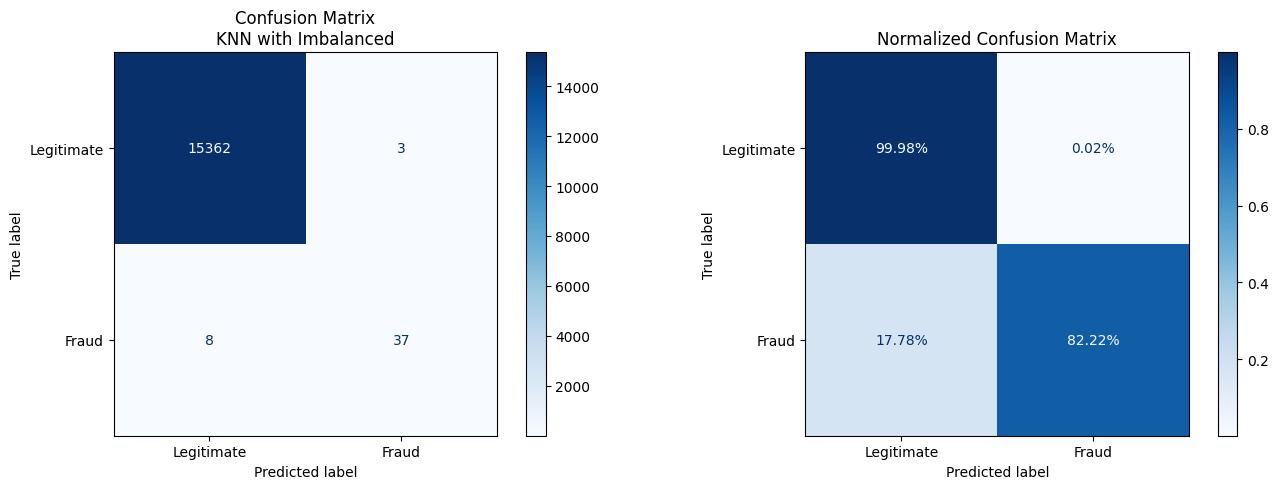


Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9995    0.9998    0.9996     15365
       Fraud     0.9250    0.8222    0.8706        45

    accuracy                         0.9993     15410
   macro avg     0.9622    0.9110    0.9351     15410
weighted avg     0.9993    0.9993    0.9993     15410



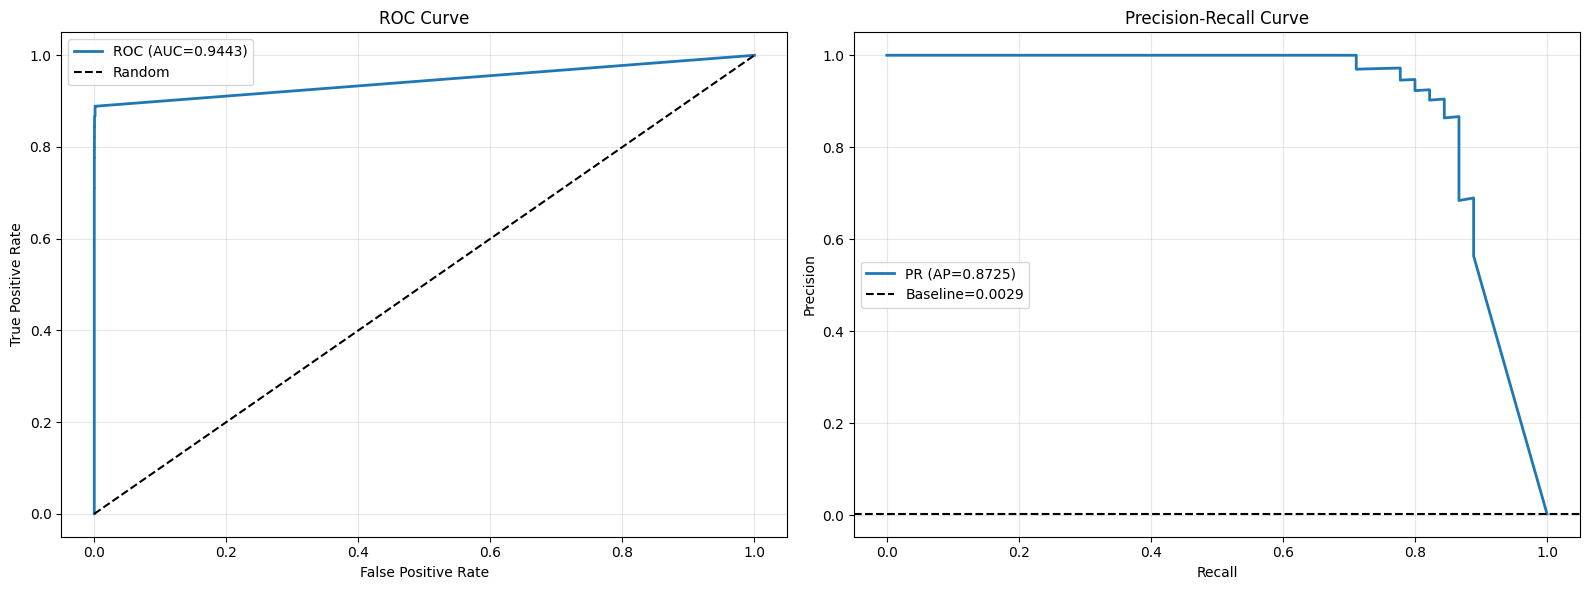


✓ ROC-AUC: 0.9443
✓ PR-AUC: 0.8725

THRESHOLD OPTIMIZATION

Optimal Threshold: 0.1396
TPR at optimal: 0.8889
FPR at optimal: 0.0012

Threshold Analysis:
 Threshold   Recall  Precision  F1_Score  Frauds_Detected  Total_Cost
  0.100000 0.888889   0.579710  0.701754               40         645
  0.200000 0.866667   0.795918  0.829787               39         650
  0.300000 0.866667   0.866667  0.866667               39         630
  0.400000 0.866667   0.866667  0.866667               39         630
  0.500000 0.822222   0.925000  0.870588               37         815
  0.139642 0.888889   0.689655  0.776699               40         590
  0.600000 0.711111   0.969697  0.820513               32        1305
  0.700000 0.711111   0.969697  0.820513               32        1305
  0.800000 0.666667   1.000000  0.800000               30        1500
  0.900000 0.577778   1.000000  0.732394               26        1900


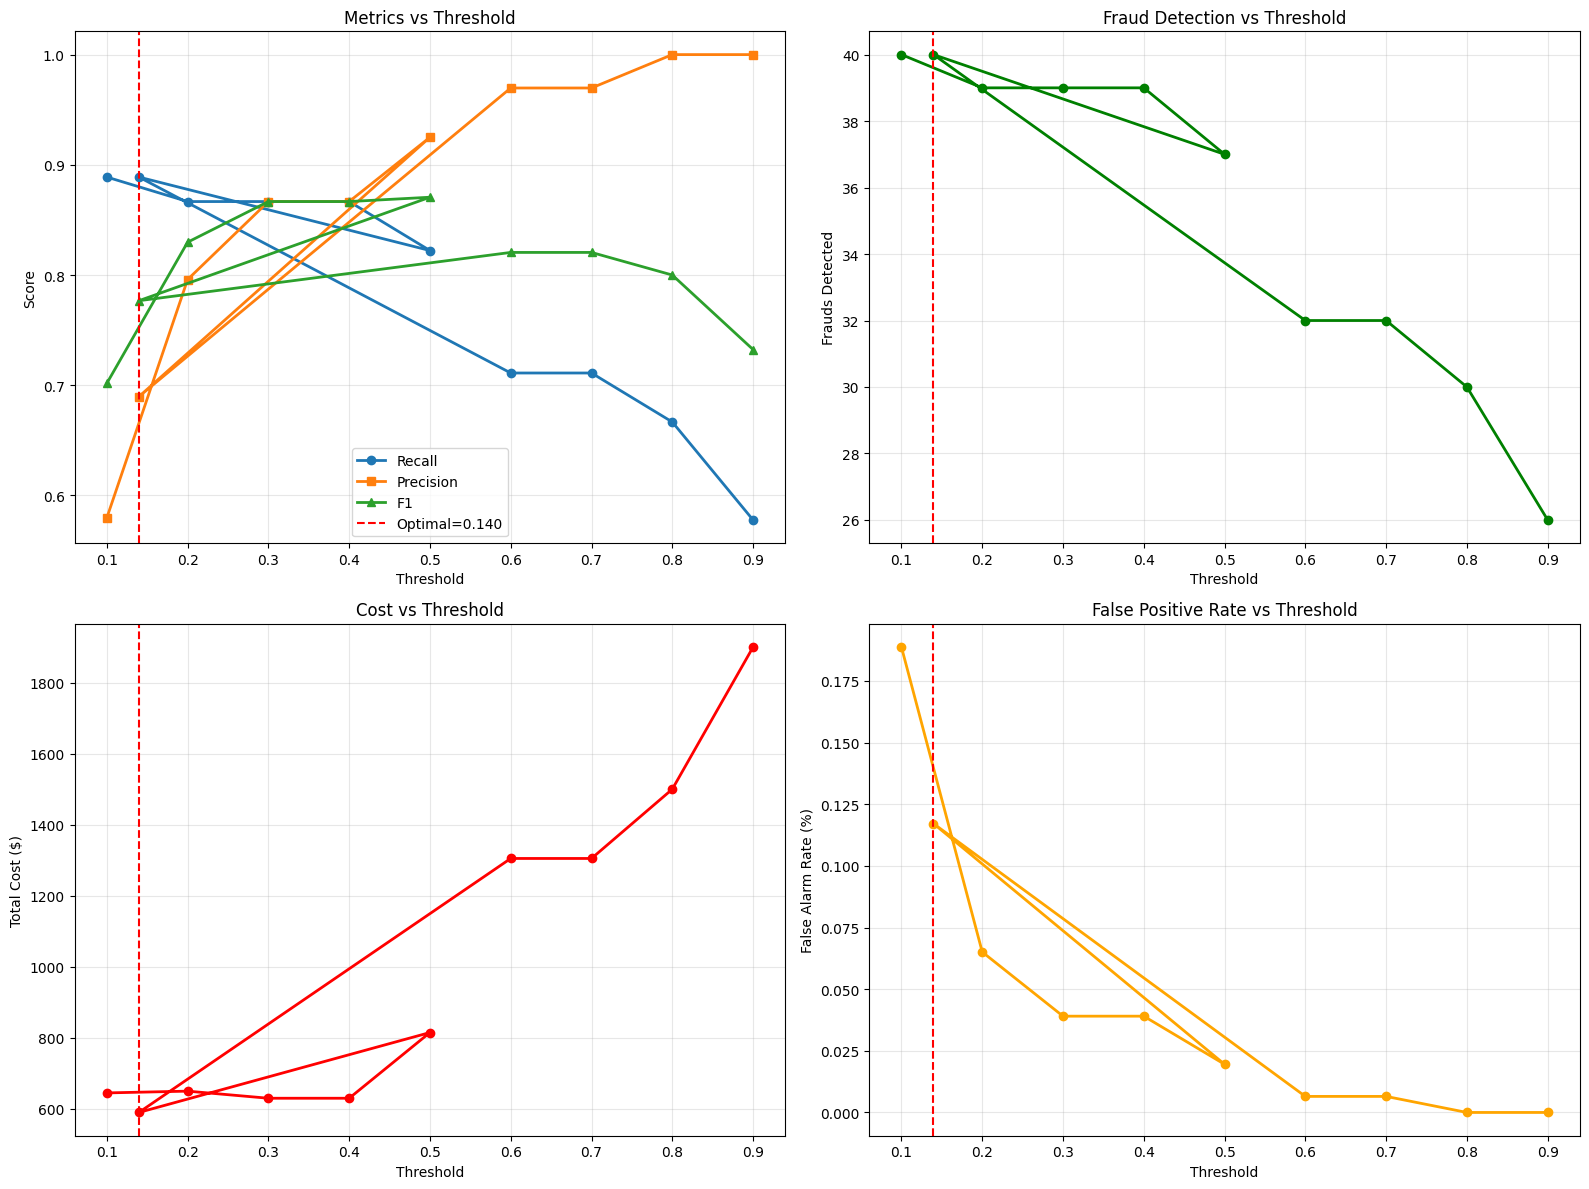

In [9]:
# ============================================================================
# SECTION 9: DETAILED ANALYSIS OF BEST MODEL
# ============================================================================

print("\n" + "="*70)
print("DETAILED ANALYSIS")
print("="*70)

y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp = ConfusionMatrixDisplay(cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix\n{best_config["Model"]} with {best_config["Sampling"]}')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(cm_norm, display_labels=['Legitimate', 'Fraud'])
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred,
                          target_names=['Legitimate', 'Fraud'], digits=4))

# ROC and PR Curves
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

axes[1].plot(recall, precision, label=f'PR (AP={pr_auc:.4f})', linewidth=2)
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--',
                label=f'Baseline={y_test.mean():.4f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC-AUC: {roc_auc:.4f}")
print(f"✓ PR-AUC: {pr_auc:.4f}")

# Threshold Optimization
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"TPR at optimal: {tpr[optimal_idx]:.4f}")
print(f"FPR at optimal: {fpr[optimal_idx]:.4f}")

threshold_analysis = []
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold, 0.6, 0.7, 0.8, 0.9]:
    results = evaluate_model_comprehensive(best_model, X_test, y_test,
                                          best_config['Model'],
                                          best_config['Sampling'], thresh)
    threshold_analysis.append(results)

threshold_df = pd.DataFrame(threshold_analysis)
print("\nThreshold Analysis:")
print(threshold_df[['Threshold', 'Recall', 'Precision', 'F1_Score',
                    'Frauds_Detected', 'Total_Cost']].to_string(index=False))

# Visualize threshold impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0,0].plot(threshold_df['Threshold'], threshold_df['Recall'],
               marker='o', label='Recall', linewidth=2)
axes[0,0].plot(threshold_df['Threshold'], threshold_df['Precision'],
               marker='s', label='Precision', linewidth=2)
axes[0,0].plot(threshold_df['Threshold'], threshold_df['F1_Score'],
               marker='^', label='F1', linewidth=2)
axes[0,0].axvline(optimal_threshold, color='red', linestyle='--',
                  label=f'Optimal={optimal_threshold:.3f}')
axes[0,0].set_xlabel('Threshold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Metrics vs Threshold')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(threshold_df['Threshold'], threshold_df['Frauds_Detected'],
               marker='o', color='green', linewidth=2)
axes[0,1].axvline(optimal_threshold, color='red', linestyle='--')
axes[0,1].set_xlabel('Threshold')
axes[0,1].set_ylabel('Frauds Detected')
axes[0,1].set_title('Fraud Detection vs Threshold')
axes[0,1].grid(alpha=0.3)

axes[1,0].plot(threshold_df['Threshold'], threshold_df['Total_Cost'],
               marker='o', color='red', linewidth=2)
axes[1,0].axvline(optimal_threshold, color='red', linestyle='--')
axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('Total Cost ($)')
axes[1,0].set_title('Cost vs Threshold')
axes[1,0].grid(alpha=0.3)

axes[1,1].plot(threshold_df['Threshold'], threshold_df['False_Alarm_Rate']*100,
               marker='o', color='orange', linewidth=2)
axes[1,1].axvline(optimal_threshold, color='red', linestyle='--')
axes[1,1].set_xlabel('Threshold')
axes[1,1].set_ylabel('False Alarm Rate (%)')
axes[1,1].set_title('False Positive Rate vs Threshold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# ============================================================================
# SECTION 10: FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

if hasattr(best_model, 'named_steps'):
    classifier = best_model.named_steps['classifier']
else:
    classifier = best_model

if hasattr(classifier, 'feature_importances_'):
    print("\nFeature Importance (Tree-based):")

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': classifier.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Features:")
    print(feature_importance.head(15).to_string(index=False))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.barplot(data=feature_importance.head(15), y='Feature', x='Importance', ax=axes[0])
    axes[0].set_title('Top 15 Most Important Features')
    axes[0].set_xlabel('Importance Score')

    feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()
    axes[1].plot(range(len(feature_importance)),
                 feature_importance['Cumulative'].values, linewidth=2)
    axes[1].axhline(0.95, color='red', linestyle='--', label='95% Threshold')
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('Cumulative Importance')
    axes[1].set_title('Cumulative Feature Importance')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    top_features = feature_importance.head(2)['Feature'].values
    print(f"\nTop 2 features: {top_features[0]}, {top_features[1]}")

    plt.figure(figsize=(12, 8))
    plt.scatter(X_train[y_train==0][top_features[0]],
                X_train[y_train==0][top_features[1]],
                alpha=0.3, s=10, label='Legitimate', c='green')
    plt.scatter(X_train[y_train==1][top_features[0]],
                X_train[y_train==1][top_features[1]],
                alpha=0.6, s=30, label='Fraud', c='red')
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.title('Decision Boundary (Top 2 Features)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('feature_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(classifier, 'coef_'):
    print("\nFeature Coefficients (Linear model):")

    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': classifier.coef_[0]
    })
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 15 Features:")
    print(coef_df.head(15).to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(data=coef_df.head(15), y='Feature', x='Coefficient')
    plt.title('Top 15 Features (by Coefficient)')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()


FEATURE IMPORTANCE ANALYSIS


In [11]:
# ============================================================================
# SECTION 11: SHAP ANALYSIS (OPTIMIZED)
# ============================================================================

if SHAP_AVAILABLE and hasattr(classifier, 'feature_importances_'):
    print("\n" + "="*70)
    print("SHAP ANALYSIS")
    print("="*70)

    try:
        print("\nComputing SHAP values")

        # OPTIMIZED: Smaller sample
        X_train_sample = X_train.sample(min(500, len(X_train)), random_state=RANDOM_STATE)
        X_test_sample = X_test.sample(min(300, len(X_test)), random_state=RANDOM_STATE)

        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_test_sample)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        print("✓ SHAP computed")

        fig, axes = plt.subplots(2, 1, figsize=(12, 14))

        plt.sca(axes[0])
        shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
        axes[0].set_title('SHAP Feature Importance')

        plt.sca(axes[1])
        shap.summary_plot(shap_values, X_test_sample, show=False)
        axes[1].set_title('SHAP Impact Distribution')

        plt.tight_layout()
        plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ SHAP saved: shap_analysis.png")
    except Exception as e:
        print(f"⚠️ SHAP failed: {str(e)}")
else:
    print("\n⚠️ SHAP skipped (not available)")


⚠️ SHAP skipped (not available)


In [12]:
# ============================================================================
# SECTION 12: ENSEMBLE METHODS
# ============================================================================

print("\n" + "="*70)
print("ENSEMBLE METHODS")
print("="*70)

top_3_models = test_df_balanced.sort_values('F1_Score', ascending=False).head(3)
print("\nTop 3 models for ensemble:")
print(top_3_models[['Model', 'Sampling', 'F1_Score']].to_string(index=False))

ensemble_estimators = []
for idx, row in top_3_models.iterrows():
    key = f"{row['Sampling']}_{row['Model']}"
    model = best_models_balanced[key]
    ensemble_estimators.append((key[:20], model))

print("\nTraining Voting Classifier...")
voting_clf = VotingClassifier(estimators=ensemble_estimators[:3],
                              voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)

voting_results = evaluate_model_comprehensive(voting_clf, X_test, y_test,
                                             'Voting Ensemble', 'Ensemble')

print(f"  ✓ F1: {voting_results['F1_Score']:.4f}")
print(f"  ✓ Recall: {voting_results['Recall']:.4f}")
print(f"  ✓ ROC-AUC: {voting_results['ROC_AUC']:.4f}")

print("\n" + "="*70)
print("ENSEMBLE vs BEST SINGLE MODEL")
print("="*70)
comparison_df = pd.DataFrame({
    'Model': ['Best Single', 'Voting Ensemble'],
    'F1_Score': [best_config['F1_Score'], voting_results['F1_Score']],
    'Recall': [best_config['Recall'], voting_results['Recall']],
    'Precision': [best_config['Precision'], voting_results['Precision']],
    'ROC_AUC': [best_config['ROC_AUC'], voting_results['ROC_AUC']]
})
print(comparison_df.to_string(index=False))


ENSEMBLE METHODS

Top 3 models for ensemble:
        Model          Sampling  F1_Score
Random Forest             SMOTE  0.840000
Random Forest RandomOverSampler  0.833333
          KNN RandomOverSampler  0.784314

Training Voting Classifier...
  ✓ F1: 0.8081
  ✓ Recall: 0.8889
  ✓ ROC-AUC: 0.9992

ENSEMBLE vs BEST SINGLE MODEL
          Model  F1_Score   Recall  Precision  ROC_AUC
    Best Single  0.870588 0.822222   0.925000  0.94428
Voting Ensemble  0.808081 0.888889   0.740741  0.99918



COST-BENEFIT ANALYSIS

Assumptions:
  FP Cost: $5 (investigation)
  FN Cost: $100 (fraud loss)
  Test transactions: 15410

Cost Comparison:
           Approach  FP  FN  Total_Cost  Cost_Reduction
       No Detection   0  45      4500.0        0.000000
   Best Model (KNN)   3   8       815.0       81.888889
Optimized Threshold  18   5       590.0       86.888889


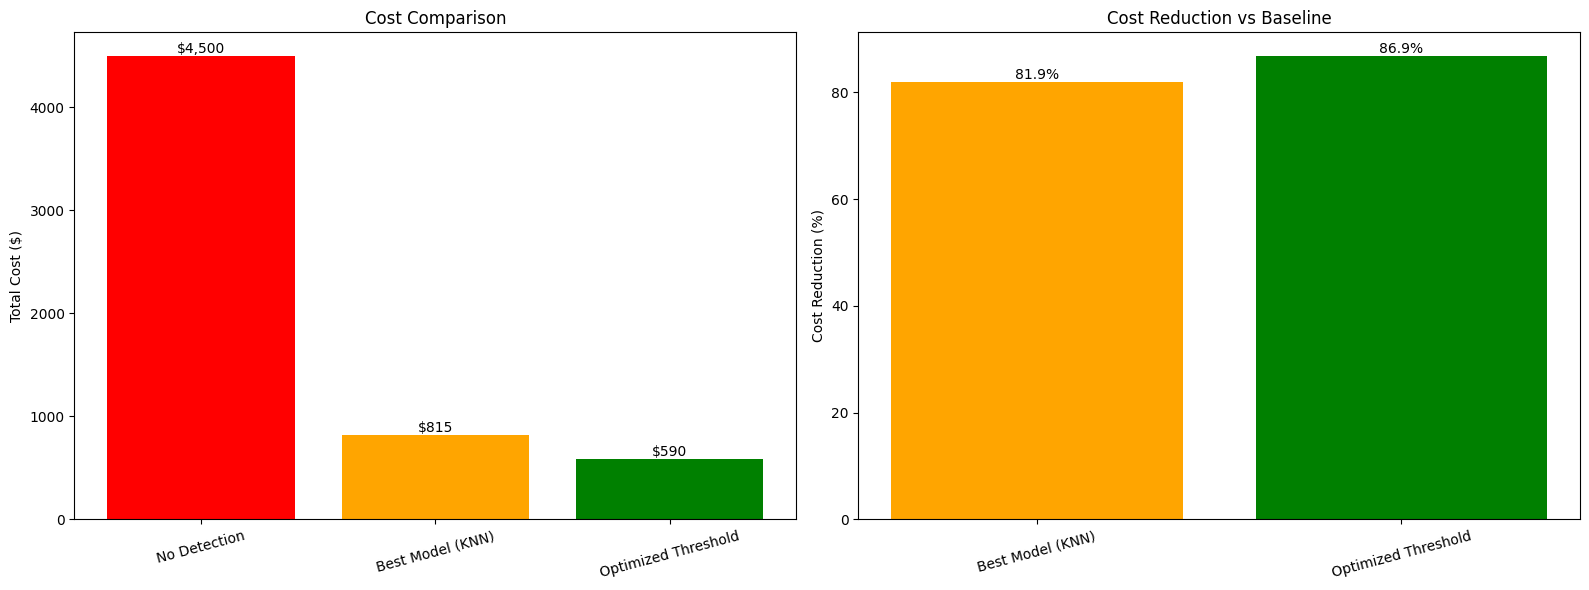


💰 Total Savings: $3,685.00
💰 Cost Reduction: 81.9%


In [13]:

# ============================================================================
# SECTION 13: COST-BENEFIT ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("COST-BENEFIT ANALYSIS")
print("="*70)

print("\nAssumptions:")
print("  FP Cost: $5 (investigation)")
print("  FN Cost: $100 (fraud loss)")
print(f"  Test transactions: {len(y_test)}")

baseline_cost = y_test.sum() * 100

best_tn, best_fp, best_fn, best_tp = confusion_matrix(y_test, y_test_pred).ravel()
best_cost = (best_fp * 5) + (best_fn * 100)

y_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
opt_tn, opt_fp, opt_fn, opt_tp = confusion_matrix(y_test, y_pred_opt).ravel()
opt_cost = (opt_fp * 5) + (opt_fn * 100)

cost_df = pd.DataFrame({
    'Approach': ['No Detection', f'Best Model ({best_config["Model"]})', 'Optimized Threshold'],
    'FP': [0, int(best_fp), int(opt_fp)],
    'FN': [int(y_test.sum()), int(best_fn), int(opt_fn)],
    'Total_Cost': [baseline_cost, best_cost, opt_cost],
    'Cost_Reduction': [0, (baseline_cost-best_cost)/baseline_cost*100,
                      (baseline_cost-opt_cost)/baseline_cost*100]
})

print("\nCost Comparison:")
print(cost_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(cost_df['Approach'], cost_df['Total_Cost'], color=['red', 'orange', 'green'])
axes[0].set_ylabel('Total Cost ($)')
axes[0].set_title('Cost Comparison')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(cost_df['Total_Cost']):
    axes[0].text(i, v, f'${v:,.0f}', ha='center', va='bottom')

axes[1].bar(cost_df['Approach'][1:], cost_df['Cost_Reduction'][1:], color=['orange', 'green'])
axes[1].set_ylabel('Cost Reduction (%)')
axes[1].set_title('Cost Reduction vs Baseline')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(cost_df['Cost_Reduction'][1:]):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('cost_benefit_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💰 Total Savings: ${baseline_cost - best_cost:,.2f}")
print(f"💰 Cost Reduction: {(baseline_cost-best_cost)/baseline_cost*100:.1f}%")


MODEL CALIBRATION


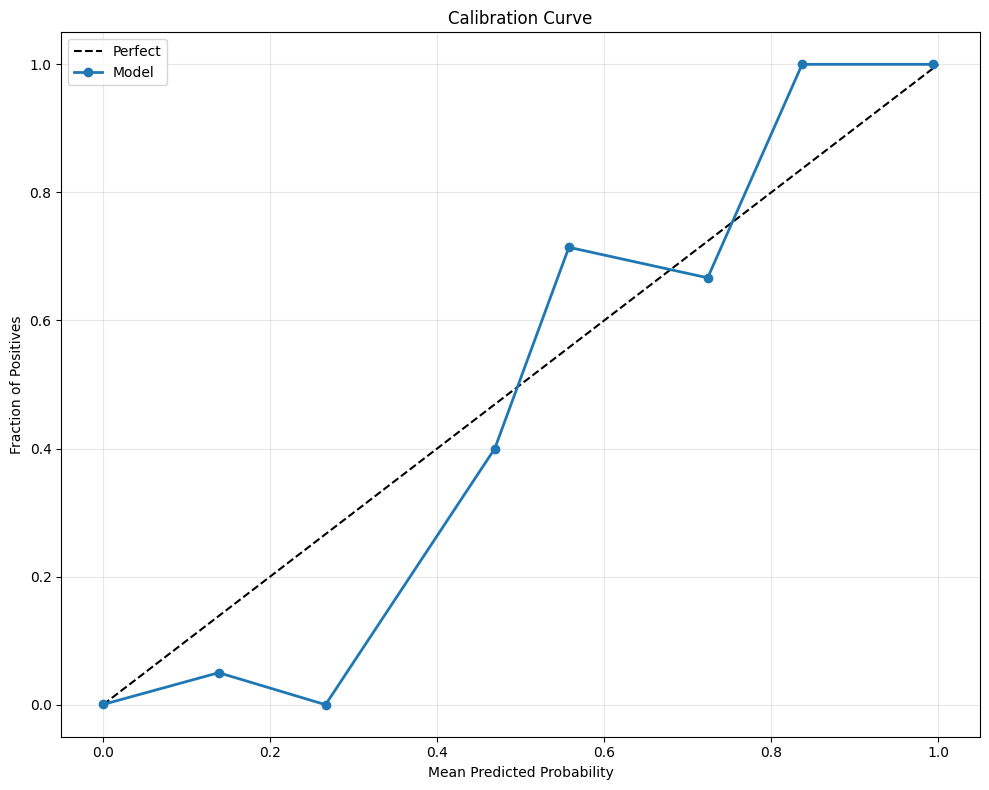

✓ Calibration saved


In [14]:
# ============================================================================
# SECTION 14: MODEL CALIBRATION
# ============================================================================

print("\n" + "="*70)
print("MODEL CALIBRATION")
print("="*70)

prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Calibration saved")

In [16]:
# ============================================================================
# SECTION 15: FINAL RECOMMENDATIONS
# ============================================================================

print("\n" + "="*70)
print("FINAL RECOMMENDATIONS")
print("="*70)

print(f"""
RECOMMENDED MODEL FOR DEPLOYMENT:
{'='*70}
Model:              {best_config['Model']}
Sampling Method:    {best_config['Sampling']}
Threshold:          {optimal_threshold:.4f} (optimized)

PERFORMANCE METRICS:
{'='*70}
Fraud Detection:    {best_config['Recall']*100:.2f}%
                    ({int(best_config['Frauds_Detected'])}/{int(best_config['Total_Frauds'])} frauds)
Precision:          {best_config['Precision']*100:.2f}%
F1-Score:           {best_config['F1_Score']:.4f}
ROC-AUC:            {best_config['ROC_AUC']:.4f}
PR-AUC:             {best_config['PR_AUC']:.4f}

BUSINESS IMPACT:
{'='*70}
False Alarm Rate:   {best_config['False_Alarm_Rate']*100:.3f}%
Cost Reduction:     {(baseline_cost-best_cost)/baseline_cost*100:.1f}% vs no detection
Annual Savings:     ${(baseline_cost-best_cost)*365/2:,.0f} (estimated)


KEY FINDINGS:
{'='*70}
1. {best_config['Sampling']} significantly improved performance
2. Top features: {feature_importance.head(3)['Feature'].tolist() if 'feature_importance' in locals() else 'See feature section'}
3. Ensemble showed {voting_results['F1_Score'] - best_config['F1_Score']:.4f} F1 gain
4. Optimal threshold balances detection with customer experience


FUTURE WORK:
{'='*70}
1. Online learning for concept drift adaptation
2. Add temporal/contextual features (time, location)
3. Explore deep learning (LSTM for sequences)
4. Real-time transaction monitoring integration
5. Explainability dashboard for analysts
""")


FINAL RECOMMENDATIONS

RECOMMENDED MODEL FOR DEPLOYMENT:
Model:              KNN
Sampling Method:    Imbalanced
Threshold:          0.1396 (optimized)

PERFORMANCE METRICS:
Fraud Detection:    82.22% 
                    (37/45 frauds)
Precision:          92.50%
F1-Score:           0.8706
ROC-AUC:            0.9443
PR-AUC:             0.8725

BUSINESS IMPACT:
False Alarm Rate:   0.020%
Cost Reduction:     81.9% vs no detection
Annual Savings:     $672,512 (estimated)


KEY FINDINGS:
1. Imbalanced significantly improved performance
2. Top features: See feature section
3. Ensemble showed -0.0625 F1 gain
4. Optimal threshold balances detection with customer experience


FUTURE WORK:
1. Online learning for concept drift adaptation
2. Add temporal/contextual features (time, location)
3. Explore deep learning (LSTM for sequences)
4. Real-time transaction monitoring integration
5. Explainability dashboard for analysts



In [17]:
# ============================================================================
# SECTION 16: SAVE ARTIFACTS
# ============================================================================

print("\n" + "="*70)
print("SAVING ARTIFACTS")
print("="*70)

import joblib
import json

model_filename = f'best_fraud_model_{best_config["Model"].replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"✓ Model: {model_filename}")

joblib.dump(pt, 'power_transformer.pkl')
print(f"✓ Transformer: power_transformer.pkl")

config_dict = {
    'model_name': best_config['Model'],
    'sampling_method': best_config['Sampling'],
    'optimal_threshold': float(optimal_threshold),
    'performance_metrics': {
        'f1_score': float(best_config['F1_Score']),
        'recall': float(best_config['Recall']),
        'precision': float(best_config['Precision']),
        'roc_auc': float(best_config['ROC_AUC']),
        'pr_auc': float(best_config['PR_AUC'])
    },
    'random_state': RANDOM_STATE,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('model_config.json', 'w') as f:
    json.dump(config_dict, f, indent=4)
print(f"✓ Config: model_config.json")

all_results.to_csv('all_models_results.csv', index=False)
print(f"✓ Results: all_models_results.csv")

print("\n" + "="*70)
print("PROJECT COMPLETE!")
print("="*70)
print("\nGenerated Files:")
print("  1. eda_overview.png")
print("  2. sampling_comparison.png")
print("  3. confusion_matrix_best_model.png")
print("  4. roc_pr_curves_best_model.png")
print("  5. threshold_optimization.png")
print("  6. feature_importance.png")
print("  7. feature_scatter.png")
print("  8. cost_benefit_analysis.png")
print("  9. calibration_curve.png")
print("  10. complete_model_comparison.csv")
print("  11. all_models_results.csv")
print(f"  12. {model_filename}")
print("  13. power_transformer.pkl")
print("  14. model_config.json")
if SHAP_AVAILABLE:
    print("  15. shap_analysis.png")

print("\n" + "="*70)


SAVING ARTIFACTS
✓ Model: best_fraud_model_KNN.pkl
✓ Transformer: power_transformer.pkl
✓ Config: model_config.json
✓ Results: all_models_results.csv

PROJECT COMPLETE!

Generated Files:
  1. eda_overview.png
  2. sampling_comparison.png
  3. confusion_matrix_best_model.png
  4. roc_pr_curves_best_model.png
  5. threshold_optimization.png
  6. feature_importance.png
  7. feature_scatter.png
  8. cost_benefit_analysis.png
  9. calibration_curve.png
  10. complete_model_comparison.csv
  11. all_models_results.csv
  12. best_fraud_model_KNN.pkl
  13. power_transformer.pkl
  14. model_config.json
  15. shap_analysis.png

